# Visualize FFT Datasets

Visualize the real TNG FFT datasets and the TVB sim FFT datasets.

In [30]:
import sys
# sys.path.append('../../dnn/')
sys.path.append('../dnn/')
import time
import numpy as np
# np.random.seed(1234)
import math as m
import os

import processing
import processing.preprocessfft
from processing.util import DataHandler
import peakdetect

# import DNN frameworks
import tensorflow as tf
import keras
from sklearn.decomposition import PCA
import ntpath

sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
from datainterface.loadpatient import LoadPat
from fragility.visualize.plotwins import VisualWins

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
def convert(data):
    if isinstance(data, list): return [datum.decode("utf-8") for datum in data]
    if isinstance(data, bytes):  return data.decode('ascii')
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return map(convert, data)
    return data

def decodebytes(metadata):
    '''
    A method for decoding a metadata dictionary from bytes -> unicode.
    This type of conversion is needed when we have Python2 npz files being saved and then
    read in by the Python3.
    '''
    def convert(data):
        if isinstance(data, bytes):  return data.decode('ascii')
        if isinstance(data, dict):   return dict(map(convert, data.items()))
        if isinstance(data, tuple):  return map(convert, data)
        return data
    try:
        metadata = {k.decode("utf-8"): (v.decode("utf-8") if isinstance(v, bytes) else v) for k,v in metadata.items()}
    except AttributeError as e:
        print(e)
        
    for key in metadata.keys():
        convert(metadata[key])
    return metadata

# Visualizing The FFT Computed Data

In [51]:
patid = 'id008_gc'
patient = patid + '_sz2'
simid = patid + '_dist'

rawdatadir = '/Volumes/ADAM LI/pydata/convertedtng/'
fftdir = '/Volumes/ADAM LI/pydata/output_fft/tng/win500_step250/'
fftsimdir = '/Volumes/ADAM LI/pydata/output_fft/tvbsim/full/win500_step250/'

# load in the data
realfftfile = os.path.join(fftdir, patient, patient + '_fftmodel.npz')
simfftfile = os.path.join(fftsimdir, simid + '-1.0_fftmodel.npz')

print(realfftfile)
print(simfftfile)

/Volumes/ADAM LI/pydata/output_fft/tng/win500_step250/id008_gc_sz2/id008_gc_sz2_fftmodel.npz
/Volumes/ADAM LI/pydata/output_fft/tvbsim/full/win500_step250/id008_gc_dist-1.0_fftmodel.npz


In [52]:
# load real data
fftdata = np.load(realfftfile)
power = fftdata['power']
freqs = fftdata['freqs']
timepoints = fftdata['timepoints']
chanlabels = fftdata['chanlabels']

# load metadata for the actual patient
dataloader = LoadPat(patient, rawdatadir)
onsettime = dataloader.onset_time
offsettime = dataloader.offset_time

print(onsettime, offsettime)
print(freqs.shape)
print(timepoints.shape)
print(chanlabels.shape)
print(power.shape)
print(fftdata.keys())

75798.8281 348484.375
(129,)
(1795, 2)
(118,)
(118, 129, 1795)
['power', 'freqs', 'timepoints', 'phase', 'chanlabels']


value error in birth date probably, so just setting to nan

In [60]:
# load in the image type data
fftsimdata = np.load(simfftfile, encoding='bytes')
power = fftsimdata['power']
freqs = fftsimdata['freqs']
timepoints = fftsimdata['timepoints']
# chanlabels = fftsimdata['chanlabels']
metadata = fftsimdata['metadata'].item()
metadata = decodebytes(metadata)
gainmat = metadata['gainmat']
onsettimes = metadata['onsettimes']
offsettimes = metadata['offsettimes']
chanlabels = metadata['chanlabels']

print(fftsimdata.keys())
print(metadata.keys())
print(gainmat.shape)
print(power.shape)
print(freqs.shape)
print(timepoints.shape)
print(chanlabels.shape)

'str' object has no attribute 'decode'
['phase', 'timepoints', 'freqs', 'power', 'metadata']
dict_keys(['gainmat', 'x0norm', b'stepsize', 'pz', 'onsettimes', 'seeg_xyz', b'winsize', 'x0ez', 'regions_centers', 'regions', 'epiparams', 'offsettimes', b'seizoffsets', 'x0pz', 'ez', 'pzindices', 'patient', 'samplerate', b'seizonsets', 'ezindices', 'chanlabels'])
(103, 84)
(103, 251, 159)
(251,)
(159, 2)
(103,)


In [68]:
chanlabels = list(chanlabels)
try:
    chanlabels = [label.decode("utf-8") for label in chanlabels]
except AttributeError as e:
    print(e)
print(chanlabels)
print(chanlabels.index('R1'))

'str' object has no attribute 'decode'
['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'CR1', 'CR2', 'CR3', 'CR4', 'CR5', 'CR6', 'CR7', 'CR8', 'CR9', 'CR10', 'CR11', 'FD1', 'FD2', 'FD3', 'FD4', 'FD5', 'FD6', 'FD7', 'FD8', 'FD9', 'FD10', 'FD11', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'CC6', 'CC7', 'CC8', 'CC9', 'CC10', 'CC11', 'TP1', 'TP2', 'TP3', 'TP4', 'TP5', 'TP6', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'GPH1', 'GPH2', 'GPH3', 'GPH4', 'GPH5', 'GPH6', 'GPH7', 'GPH8', 'GPH9', 'GPH10', 'GPH11', 'GPH12', 'T1', 'T2', 'T3', 'T4', 'OR1', 'OR2', 'OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'OR8', 'OR9', 'OR10', 'OR11']
0


(<matplotlib.figure.Figure at 0x11c87d748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x121a01940>)

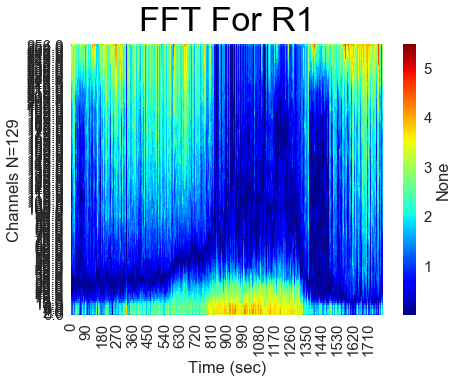

In [33]:
powwin = lambda ind: np.abs(power[ind,...].squeeze())

# plot and visualize the fft data 
chanind = 0
titlestr = 'FFT For ' + chanlabels[chanind]
sns.set(font_scale=1.5)
vizwin = VisualWins(figsize=(7,5))
vizwin.loadtimewins(timepoints)
vizwin.loaddata(powwin(chanind), freqs, sort=True)
vizwin.heatwinmodel(titlestr=titlestr)

powwin = lambda ind: np.abs(power[ind,...].squeeze())
# plot and visualize the fft data 
chanind = 0
titlestr = 'FFT For ' + chanlabels[chanind]
sns.set(font_scale=1.5)
vizwin = VisualWins(figsize=(7,5))
vizwin.loadtimewins(timepoints)
vizwin.loaddata(powwin(chanind), freqs, sort=True)
vizwin.heatwinmodel(titlestr=titlestr)

# Visualize Image Type Data

This can just be PCA projected data, or it can be image data projected onto the region parcellations of freesurfer via an inverted gain matrix.

S = G*R


In [5]:
# plot and visualize the image data compared real vs sim


